# PTO-type polarisation material analysis
This file will find the sublattices in your image. Check out Atomap.org
    for lots of information on how to use atomap.

Note: this file is not guaranteed to find what you want. It varies from image
to image. Check out the other "2_Find_Sublattices..." files or the other notebooks for different
types of materials.

In [1]:
import os
import hyperspy.api as hs
import numpy as np
import atomap.api as am
import temul.api as tml

In [2]:
# choose your matplotlib backend. qt will plot in a separate window.
# %matplotlib notebook

import matplotlib
matplotlib.pyplot.style.use("grayscale")

## Load the file or some dummy data

Hyperspy can load many different filetypes: dm3, dm4, emd, tif.
Check their website!

In [3]:
# Example dummy dataset for testing

from temul.dummy_data import get_polarisation_dummy_dataset
atom_lattice = get_polarisation_dummy_dataset(image_noise=True)
image = atom_lattice.signal

In [4]:
''' Set the directory (what folder your data is in!)
    Notice the slashes must be forward slashes. 
    Load your file
'''
# directory = 'C:/Users/Example/notice/the/forward/slashes'
# os.chdir(directory)

# Or load an actual dataset
# image = hs.load('example_awesome_image.tif')

' Set the directory (what folder your data is in!)\n    Notice the slashes must be forward slashes. \n    Load your file\n'

<IPython.core.display.Javascript object>


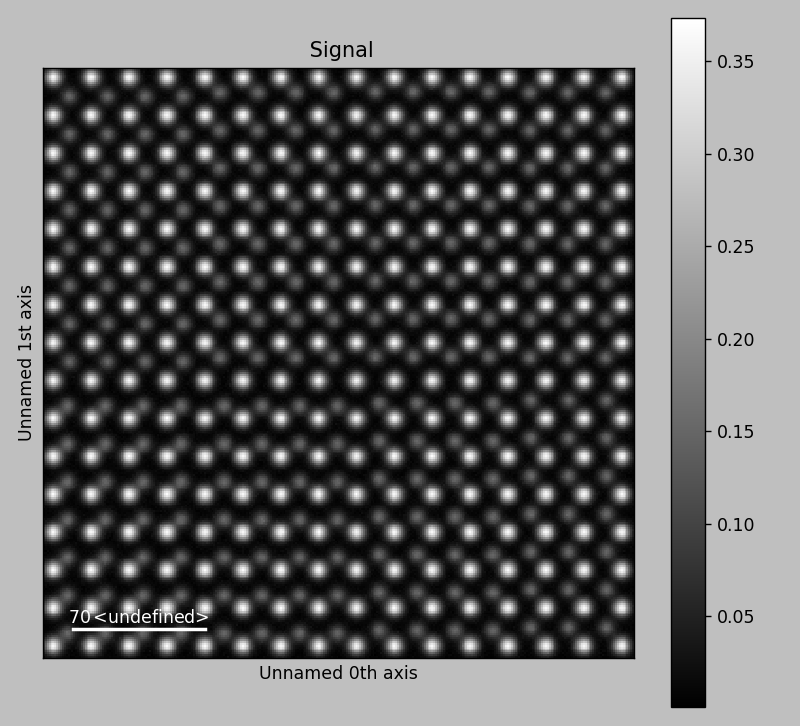

In [5]:
# plot the image to see how it looks!
image.plot()

In [6]:
# set the pixel size (called sampling in this toolkit) and the units

sampling = image.axes_manager[-1].scale
units = image.axes_manager[-1].units

print(sampling)  # if sampling is 1, then the image is probably not calibrated.

1.0


## Find the atom positions
Get the Pixel separation between the atoms in your first sublattice

Note: If you have used the image filter file, then replace "image" with
"image_ifft" or whatever you called your filtered file.

  0%|          | 0/15 [00:00<?, ?it/s]

[########################################] | 100% Completed |  0.1s


  0%|          | 0/445 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


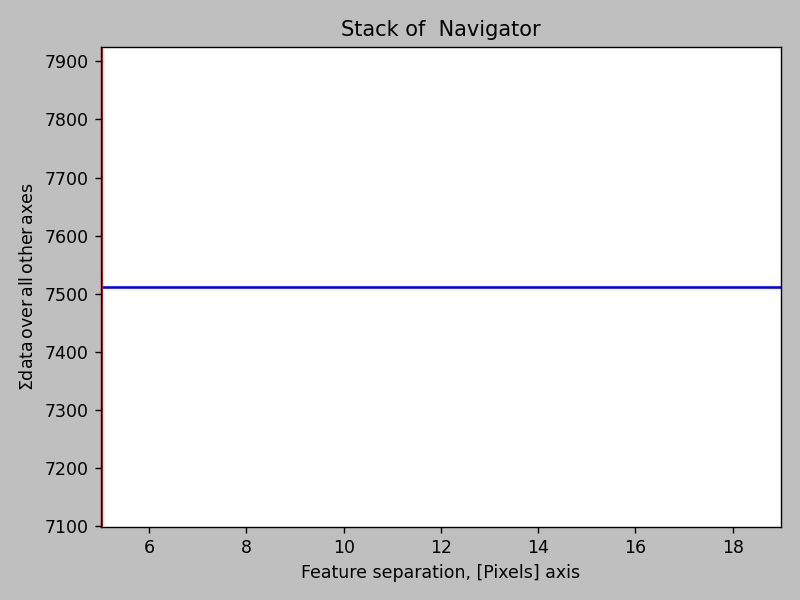

<IPython.core.display.Javascript object>


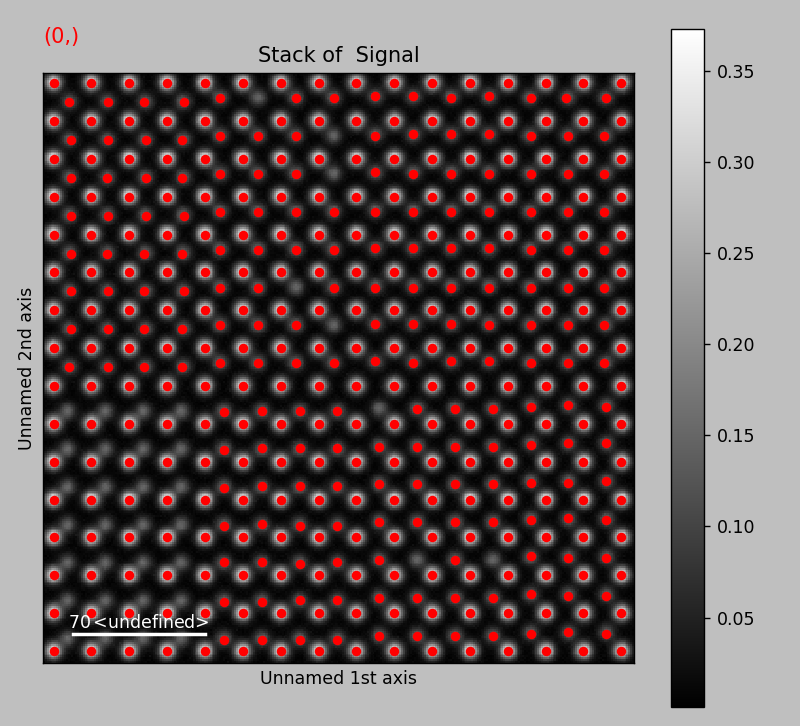

In [7]:
# look at the different pixel separations available, this can take some time.

feat = am.get_feature_separation(image, separation_range=(5, 20), pca=True)
feat.plot()

If you're happy with one of the pixel separations, then set it below. If
    you're not, you may need to change your separation_range or filter your
    image with the "1b_Filter_Data.py" file.

Note: If you have used the image filter file, then replace "image" with
"image_ifft" or whatever you called your filtered file.    


In [8]:
sep = 7  # just an example

atom_positions1 = am.get_atom_positions(image, separation=sep, pca=True)
# save these original sub1 positions!

np.save('atom_positions1.npy', arr=atom_positions1)
# how to reload this file format
# example_positions = np.load('atom_positions1.npy')

### Create the first sublattice, which we call sub1

In [9]:
sub1 = am.Sublattice(atom_position_list=atom_positions1,
                     image=image, color='red')

sub1.find_nearest_neighbors()
# you can plot the sublattice easily with:
# sub1.plot()

In [10]:
# You can refine the sublattice easily with a 2D Gaussian or COM algorithm:

sub1.refine_atom_positions_using_2d_gaussian(percent_to_nn=0.2)
# sub1.refine_atom_positions_using_center_of_mass(percent_to_nn=0.2)

np.save('atom_positions1_refined.npy', [sub1.x_position, sub1.y_position])

Gaussian fitting:   0%|          | 0/196 [00:00<?, ?it/s]

In [11]:
# this is needed to create the second sublattice:

sub1.construct_zone_axes()
# sub1.plot_planes()  # this can take a long time for large images!

### Create the second sublattice - sub2.

We have to choose the zone_axes that will give you the correct atoms positions
along the atom plane lines. To visualise the atom planes, use
sub1.plot_planes() which can take a long time for certain images.

In [12]:
zone_axis_A = sub1.zones_axis_average_distances[2]
# use this function to choose a position between atoms defined by the
# vector_fraction

atom_positions2 = sub1.find_missing_atoms_from_zone_vector(
    zone_axis_A, vector_fraction=0.5)
# save these positions 

np.save('atom_positions2_ideal.npy', arr=atom_positions2)

sub2 = am.Sublattice(atom_position_list=atom_positions2,
                     image=image, color='blue')

sub2.find_nearest_neighbors()
# sub2.plot()

sub2.refine_atom_positions_using_2d_gaussian(percent_to_nn=0.4)
# sub2.refine_atom_positions_using_center_of_mass(percent_to_nn=0.2)

np.save('atom_positions2_refined.npy', [sub2.x_position, sub2.y_position])

Gaussian fitting:   0%|          | 0/169 [00:00<?, ?it/s]

### Create and save the Atom Lattice Object
This contains our two sublattices.

In [13]:
atom_lattice = am.Atom_Lattice(image=image.data,
                               name='PTO-type structure',
                               sublattice_list=[sub1, sub2])

atom_lattice.save(filename="Atom_Lattice.hdf5", overwrite=True)


<IPython.core.display.Javascript object>


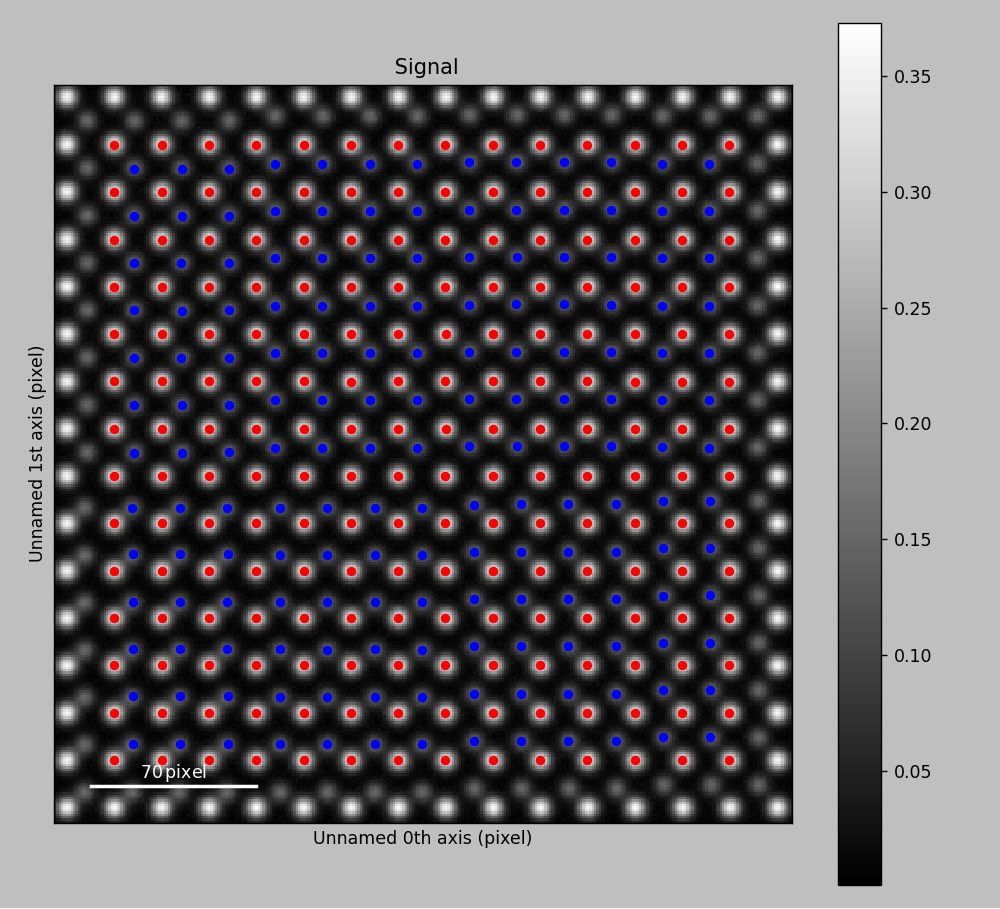

In [14]:
atom_lattice.plot()

## Find the polarisation vectors
Now we need to get the (x, y) and (u, v) data for the polarisation vectors.
This requires the relevant sublattice's original "ideal" positions and refined "actual" positions.

We can use Atomap or the Temul toolkit to do this easily with the save information from above.


In [15]:
# Atomap method (if this doesn't work, try the Temul method below)

za0, za1 = sub1.zones_axis_average_distances[0:2]

s_p = sub1.get_polarization_from_second_sublattice(
    za0, za1, sub2, color='cyan')

vector_list = s_p.metadata.vector_list
x, y = [i[0] for i in vector_list], [i[1] for i in vector_list]
u, v = [i[2] for i in vector_list], [i[3] for i in vector_list]
x, y, u, v = np.asarray(x), np.asarray(y), np.asarray(u), np.asarray(v)


In [16]:
# Temul method, only use this if the above Atomap method doesn't work

atom_positions_A = np.load('atom_positions2_ideal.npy')
atom_positions_B = np.load('atom_positions2_refined.npy').T
x, y = atom_positions_A[:, 0], atom_positions_A[:, 1]

u, v = tml.find_polarisation_vectors(atom_positions_A=atom_positions_A,
                                     atom_positions_B=atom_positions_B)

u, v = np.asarray(u), np.asarray(v)


## Plot the polarisation vectors.

Set the parameters below. Don't be overwhelmed, plot_style is the most important input! Many of the rest
you can ignore.

Note: image, sampling, units are loaded from the initial loading step, but you
      can do that here.
Note: u, v, x, y are all loaded from the previous step


<IPython.core.display.Javascript object>


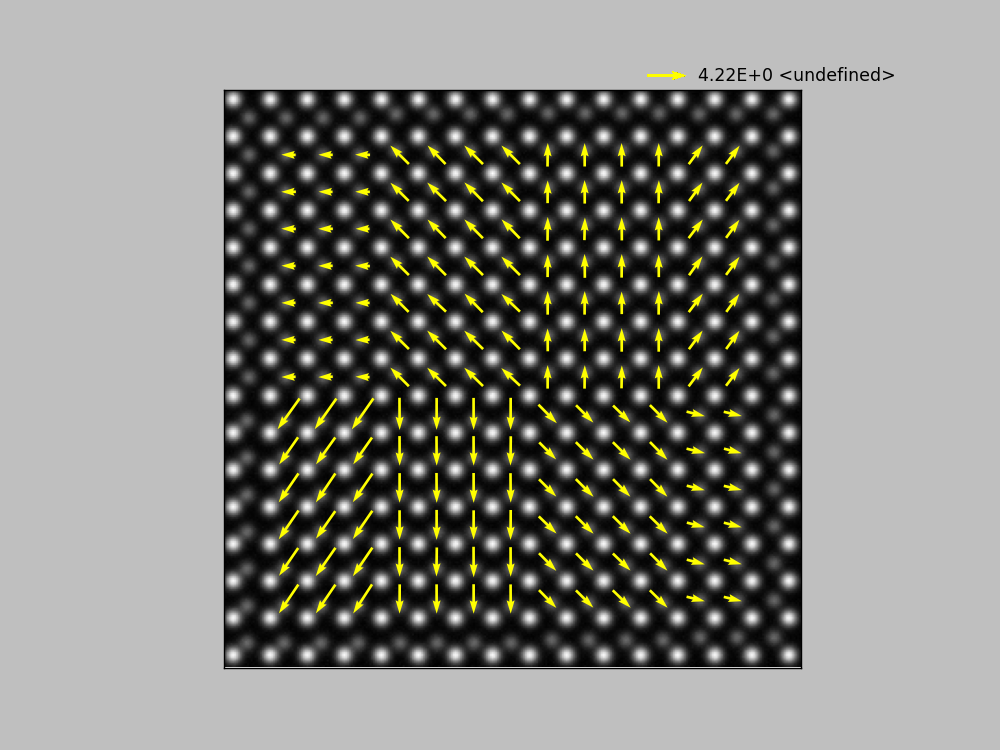

In [17]:
save = None  # save = 'example_name' will save the image
# plot_style options are:
#   'vector', 'colormap', 'contour, 'colorwheel', 'polar_colorwheel'
# for the DPC-style colorwheel just use plot_style = 'polar_colorwheel'

plot_style = 'vector'
overlay = True  # the vectors will be plotted on the image
unit_vector = False  # formerly called normalise
vector_rep = 'magnitude'  # 'magnitude' or 'angle'
degrees = False  # Set to True for degrees, False for radians
angle_offset = None
title = ""
color = 'yellow'  # may be ignored depending on the plot_style
cmap = 'viridis'  # may be ignored depending on the plot_style
alpha = 1.0  # transparency of image or vectors, depending on plot_style
image_cmap = 'gray'
ticks = None
scalebar = False
monitor_dpi = None  # set to ~200 to make too-large images a bit smaller
no_axis_info = True  
invert_y_axis = True
antialiased = False  # relevant for the contour mapping
levels = 20  # relevant for the contour mapping
remove_vectors = False
scale = None  # set to 0.001-0.01 to change arrow size
width = None  # set to ~0.005 for chunky (thicker) arrows
minshaft = 1
minlength = 1
headwidth = 3.0
headlength = 5.0
headaxislength = 4.5
quiver_units = 'width'
pivot = 'middle'
angles = 'xy'
scale_units = 'xy'

# plot the vectors!
ax_vectors = tml.plot_polarisation_vectors(
    x, y, u, v, image.data, sampling=sampling, units=units,
    plot_style=plot_style, overlay=overlay, unit_vector=unit_vector,
    vector_rep=vector_rep, degrees=degrees, angle_offset=angle_offset,
    save=save, title=title, color=color, cmap=cmap, alpha=alpha,
    image_cmap=image_cmap, monitor_dpi=monitor_dpi,
    no_axis_info=no_axis_info, invert_y_axis=invert_y_axis, ticks=ticks,
    scalebar=scalebar, antialiased=antialiased, levels=levels,
    remove_vectors=remove_vectors, quiver_units=quiver_units, pivot=pivot,
    angles=angles, scale_units=scale_units, scale=scale, headwidth=headwidth,
    headlength=headlength, headaxislength=headaxislength, width=width,
    minshaft=minshaft, minlength=minlength)
